In [2]:
# Import dependencies
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 400)

In [4]:
# Read the data into a Pandas DataFrame
df = pd.read_csv('resources/play_by_play_2024_cleaned.csv')
df.head()

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,return_touchdown,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa
0,1,2024_01_ARI_BUF,NaN,NaN,NaN,NaN,NaN,BUF 35,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Touchdown,NaN,NaN,0.000000
1,40,2024_01_ARI_BUF,ARI,BUF,BUF,35.0,NaN,BUF 35,0,kickoff,...,0.0,0.0,0.0,NaN,NaN,NaN,Touchdown,7:13,TOUCHDOWN,0.257819
2,61,2024_01_ARI_BUF,ARI,BUF,ARI,70.0,1.0,ARI 30,10,run,...,0.0,0.0,0.0,NaN,NaN,3.0,Touchdown,7:13,TOUCHDOWN,-0.200602
3,83,2024_01_ARI_BUF,ARI,BUF,ARI,67.0,2.0,ARI 33,7,pass,...,0.0,0.0,0.0,22.0,22.0,NaN,Touchdown,7:13,TOUCHDOWN,2.028874
4,108,2024_01_ARI_BUF,ARI,BUF,BUF,45.0,1.0,BUF 45,10,pass,...,0.0,0.0,0.0,9.0,9.0,NaN,Touchdown,7:13,TOUCHDOWN,0.754242


### Question #1
---
**Ruby Bhatia**
- How do teams perform offensively and defensively in NFL Week 1 games?


### Question #2
----
**Nathan Roller**
- What are tendencies for teams in specific down and distance situations? 


### Question #3 
---
**Justin Nolan**
- How do different team statistics correlate with winning outcomes in Week 1 games?


### Question #4
---
**Darell Johnson**

- What are the conversion rates for possession downs? What tendencies did you identify?

In [19]:
money_down = df[(df['down'].isin([3, 4])) & (df['ydstogo'] <= 3)].copy()  
money_down.loc[:, 'yards_gained'] = money_down[['passing_yards', 'rushing_yards']].sum(axis=1)


money_down.loc[:, 'result'] = money_down.apply(
    lambda row: 'first_down' if row['yards_gained'] >= row['ydstogo'] else 'turnover_on_downs',
    axis=1
)

money_down

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa,result
63,1622,2024_01_ARI_BUF,BUF,ARI,BUF,61.0,3.0,BUF 39,1,no_play,...,0.0,0.0,NaN,NaN,NaN,Touchdown,2:21,TOUCHDOWN,-0.800535,turnover_on_downs
102,2608,2024_01_ARI_BUF,BUF,ARI,ARI,13.0,3.0,ARI 13,2,run,...,0.0,0.0,NaN,NaN,1.0,Touchdown,2:48,TOUCHDOWN,-0.816518,turnover_on_downs
103,2632,2024_01_ARI_BUF,BUF,ARI,ARI,12.0,4.0,ARI 12,1,run,...,0.0,0.0,NaN,NaN,1.0,Touchdown,2:48,TOUCHDOWN,1.343717,first_down
123,3124,2024_01_ARI_BUF,BUF,ARI,ARI,37.0,4.0,ARI 37,2,run,...,0.0,0.0,NaN,NaN,5.0,Touchdown,4:48,TOUCHDOWN,2.453890,first_down
148,3741,2024_01_ARI_BUF,BUF,ARI,ARI,20.0,3.0,ARI 20,2,run,...,0.0,0.0,NaN,NaN,-1.0,Field goal,2:34,FIELD_GOAL,-1.196253,turnover_on_downs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,2155,2024_01_WAS_TB,WAS,TB,TB,40.0,3.0,TB 40,1,run,...,0.0,0.0,NaN,NaN,0.0,Missed field goal,5:39,MISSED_FG,-1.728518,turnover_on_downs
2503,2189,2024_01_WAS_TB,WAS,TB,TB,40.0,4.0,TB 40,1,run,...,0.0,0.0,NaN,NaN,2.0,Missed field goal,5:39,MISSED_FG,2.318735,first_down
2523,2695,2024_01_WAS_TB,TB,WAS,TB,69.0,3.0,TB 31,3,pass,...,0.0,0.0,NaN,NaN,NaN,Punt,1:32,PUNT,-2.572418,turnover_on_downs
2559,3603,2024_01_WAS_TB,TB,WAS,WAS,1.0,3.0,WAS 1,1,pass,...,0.0,0.0,1.0,1.0,NaN,Touchdown,7:38,TOUCHDOWN,1.343011,first_down


In [21]:
money_down = money_down[['play_id', 'down', 'ydstogo', 'yards_gained','play_type', 'air_yards', 'result']]
money_down

,play_id,down,ydstogo,yards_gained,play_type,air_yards,result
63,1622,3.0,1,0.0,no_play,NaN,turnover_on_downs
102,2608,3.0,2,1.0,run,NaN,turnover_on_downs
103,2632,4.0,1,1.0,run,NaN,first_down
123,3124,4.0,2,5.0,run,NaN,first_down
148,3741,3.0,2,-1.0,run,NaN,turnover_on_downs
...,...,...,...,...,...,...,...
2502,2155,3.0,1,0.0,run,NaN,turnover_on_downs
2503,2189,4.0,1,2.0,run,NaN,first_down
2523,2695,3.0,3,0.0,pass,NaN,turnover_on_downs
2559,3603,3.0,1,1.0,pass,1.0,first_down


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

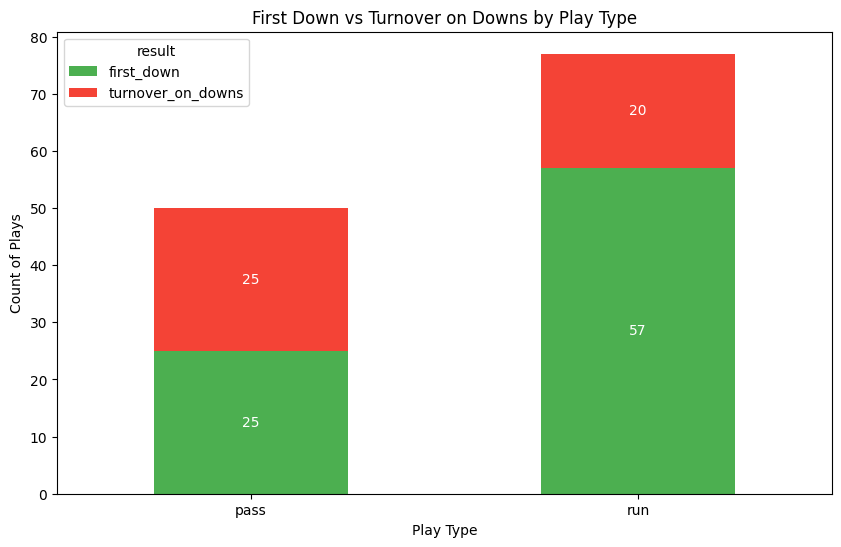

In [31]:
import os
import matplotlib.pyplot as plt

def create_stacked_bar_chart_with_labels(data, save_path):
    # Group by play_type and result to get counts
    grouped = data.groupby(['play_type', 'result']).size().unstack()

    custom_colors = ['#4CAF50', '#F44336']
    ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)
    
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fmt='%d', color='white', fontsize=10)
    
    plt.title('First Down vs Turnover on Downs by Play Type')
    plt.xlabel('Play Type')
    plt.ylabel('Count of Plays')
    plt.xticks(rotation=0)


    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


filtered_data = money_down[money_down['play_type'].isin(['run', 'pass'])]


images_folder = r'C:\Repos\NFL_2024_Week_1\Images'
image_path = os.path.join(images_folder, 'Money_Down.png')


create_stacked_bar_chart_with_labels(filtered_data, image_path)


In [34]:
first_down_pass = money_down[(money_down['result'] == 'first_down') & (money_down['play_type'] == 'pass')]
first_down_pass.head()

,play_id,down,ydstogo,yards_gained,play_type,air_yards,result
274,2717,3.0,3,10.0,pass,5.0,first_down
767,1786,3.0,2,19.0,pass,17.0,first_down
862,4030,4.0,2,7.0,pass,6.0,first_down
875,4333,3.0,3,5.0,pass,5.0,first_down
930,988,3.0,1,8.0,pass,6.0,first_down


In [56]:
first_down_pass = money_down[(money_down['result'] == 'first_down') & (money_down['play_type'] == 'pass')].copy()
first_down_pass.loc[:, 'air_yard_category'] = pd.cut(
    first_down_pass['air_yards'], 
    bins=[-float('inf'), 0, 3, 7, float('inf')], 
    labels=['<= 0', '> 0 and <= 3', '> 3 and <= 7', '> 7']
)
grouped_by_air_yards = first_down_pass.groupby('air_yard_category', observed=True).size()
grouped_by_air_yards

air_yard_category
<= 0            3
> 0 and <= 3    7
> 3 and <= 7    9
> 7             6
dtype: int64

C:\Users\dljoh\AppData\Local\Temp\ipykernel_20860\2928142308.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_air_yards = first_down_pass.groupby('air_yard_category').size()


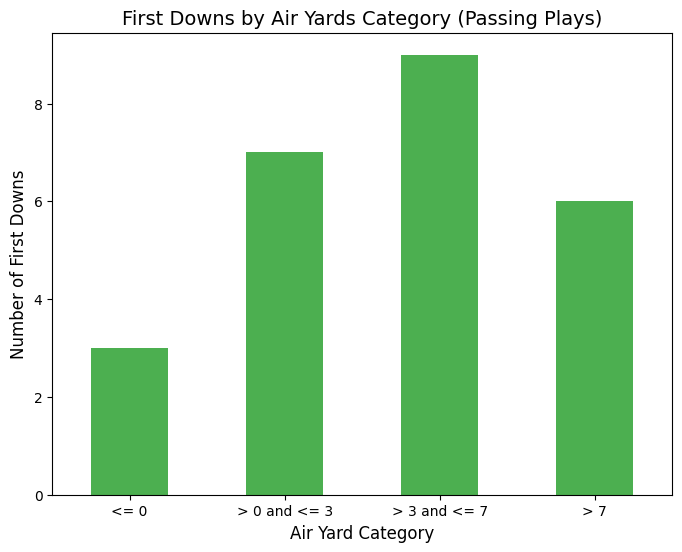

In [78]:
import matplotlib.pyplot as plt

grouped_by_air_yards = first_down_pass.groupby('air_yard_category').size()

plt.figure(figsize=(8, 6))
grouped_by_air_yards.plot(kind='bar', color='#4CAF50')

plt.title('First Downs by Air Yards Category (Passing Plays)', fontsize=14)
plt.xlabel('Air Yard Category', fontsize=12)
plt.ylabel('Number of First Downs', fontsize=12)
images_folder = r'C:\Repos\NFL_2024_Week_1\Images'
image_path = os.path.join(images_folder, 'Successful Passing.png')  # You can change the file name and format if needed
    
plt.savefig(image_path, bbox_inches='tight')
# Show the plot
plt.xticks(rotation=0)  # Ensures the category labels are horizontal
plt.show()
